In [6]:
import os
from google.colab import files
# Ensure Kaggle directory exists
if not os.path.exists('/root/.kaggle'):
  os.makedirs('/root/.kaggle')
  # Upload kaggle.json if it doesn't exist
  if not os.path.exists('/root/.kaggle/kaggle.json'):
    uploaded = files.upload()
    for fn in uploaded.keys():
      if fn == 'kaggle.json':
        os.rename(fn, '/root/.kaggle/kaggle.json')
        os.chmod('/root/.kaggle/kaggle.json', 600)
        print("Kaggle API token uploaded and configured.")
    else:
      print(f"Ignoring file: {fn}. Please upload kaggle.json.")
else:
  print("Kaggle API token already exists.")

Kaggle API token already exists.


In [7]:
!pip install nixtla

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split # We'll use manual split later
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import nixtla
from nixtla import NixtlaClient

# Display settings for better readability in Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
print("Libraries imported.")

Libraries imported.


In [9]:
# Create data directory if it doesn't exist
if not os.path.exists('./data'):
    os.makedirs('./data')

# Download and unzip dataset (make sure kaggle.json is set up!)
!kaggle datasets download -d koheimuramatsu/iot-temperature-forecasting --unzip -p ./data

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [10]:
# Adjust filename if necessary
csv_file_path = './data/iot_temp.csv'
df = pd.read_csv(csv_file_path)
print(f"Dataset loaded from {csv_file_path}")
print(f"Shape of dataset: {df.shape}")
print("First 5 rows:")
print(df.head())

Dataset loaded from ./data/iot_temp.csv
Shape of dataset: (97606, 5)
First 5 rows:
                                    id  room_id/id        noted_date  temp  \
0  __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30    29   
1  __export__.temp_log_196131_7bca51bc  Room Admin  08-12-2018 09:30    29   
2  __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29    41   
3  __export__.temp_log_196128_be0919cf  Room Admin  08-12-2018 09:29    41   
4  __export__.temp_log_196126_d30b72fb  Room Admin  08-12-2018 09:29    31   

  out/in  
0     In  
1     In  
2    Out  
3    Out  
4     In  



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97606 entries, 0 to 97605
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          97606 non-null  object
 1   room_id/id  97606 non-null  object
 2   noted_date  97606 non-null  object
 3   temp        97606 non-null  int64 
 4   out/in      97606 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.7+ MB

--- Statistical Summary ---
               temp
count  97606.000000
mean      35.053931
std        5.699825
min       21.000000
25%       30.000000
50%       35.000000
75%       40.000000
max       51.000000

--- Missing Values ---
id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64

No missing 'temp' values found.


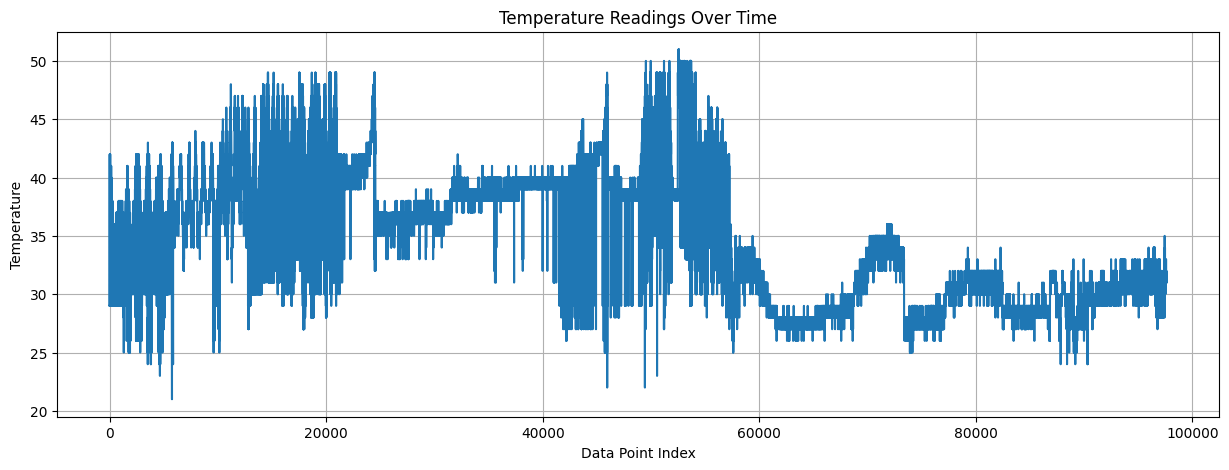

In [11]:
print("\n--- Data Info ---")
df.info()
print("\n--- Statistical Summary ---")
print(df.describe())
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Handle missing temperature values
if df['temp'].isnull().sum() > 0:
    df['temp'].fillna(method='ffill', inplace=True)
    print(f"\nFilled missing 'temp' values using forward fill.")
    print(f"Missing 'temp' values remaining: {df['temp'].isnull().sum()}")
else:
    print("\nNo missing 'temp' values found.")

# Visualize outliers
plt.figure(figsize=(15,5))
df['temp'].plot(title='Temperature Readings Over Time')
plt.ylabel('Temperature')
plt.xlabel('Data Point Index')
plt.grid(True)
plt.show()

In [12]:
# Convert 'noted_date' to datetime objects
df['noted_date'] = pd.to_datetime(df['noted_date'], format='%d-%m-%Y %H:%M', dayfirst=True, errors='coerce')
# Check for any rows that failed to parse
if df['noted_date'].isnull().any():
    print(f"\nWarning: {df['noted_date'].isnull().sum()} rows failed to parse as datetime. Inspect these rows:")
    print(df[df['noted_date'].isnull()])
# Set 'noted_date' as the index
df = df.set_index('noted_date')
# Sort the index chronologically
df = df.sort_index()
# Optional: Drop the original 'id' columns if not needed
# df = df.drop(columns=['id', 'room_id/id'], errors='ignore')
print("\nConverted 'noted_date' to datetime index and sorted.")
print(f"Index type: {df.index.dtype}")
print(f"Data ranges from {df.index.min()} to {df.index.max()}")
print("DataFrame head with datetime index:")
print(df.head())


Converted 'noted_date' to datetime index and sorted.
Index type: datetime64[ns]
Data ranges from 2018-07-28 07:06:00 to 2018-12-08 09:30:00
DataFrame head with datetime index:
                                                      id  room_id/id  temp  \
noted_date                                                                   
2018-07-28 07:06:00  __export__.temp_log_133741_32958703  Room Admin    31   
2018-07-28 07:06:00  __export__.temp_log_123297_4d8e690b  Room Admin    31   
2018-07-28 07:06:00  __export__.temp_log_100386_84093a68  Room Admin    31   
2018-07-28 07:07:00  __export__.temp_log_118398_6ebe504d  Room Admin    31   
2018-07-28 07:07:00  __export__.temp_log_144221_a4f20688  Room Admin    31   

                    out/in  
noted_date                  
2018-07-28 07:06:00     In  
2018-07-28 07:06:00     In  
2018-07-28 07:06:00     In  
2018-07-28 07:07:00     In  
2018-07-28 07:07:00     In  


In [13]:
target_column = 'temp'
# Calculate split point (80% of data length)
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
# Split the DataFrame
train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()
print(f"\nSplitting data at index {split_index}.")
print(f"Training set shape: {train_df.shape}, from {train_df.index.min()} to {train_df.index.max()}")
print(f"Testing set shape: {test_df.shape}, from {test_df.index.min()} to {test_df.index.max()}")


Splitting data at index 78084.
Training set shape: (78084, 4), from 2018-07-28 07:06:00 to 2018-10-23 02:42:00
Testing set shape: (19522, 4), from 2018-10-23 02:48:00 to 2018-12-08 09:30:00


In [14]:
scaler = MinMaxScaler()
scaled_column_name = target_column + '_scaled'

# Fit the scaler on the training data only and transform it
train_df[scaled_column_name] = scaler.fit_transform(train_df[[target_column]])
# Transform the test data using the same scaler
test_df[scaled_column_name] = scaler.transform(test_df[[target_column]])
print("\nApplied MinMaxScaler (0-1 scaling) to 'temp' column.")
print("Scaler min/max learned from training data:", scaler.data_min_, scaler.data_max_)
print("Example scaled values in training data:")
print(train_df[[target_column, scaled_column_name]].head())
print("\nExample scaled values in testing data:")
print(test_df[[target_column, scaled_column_name]].head())


Applied MinMaxScaler (0-1 scaling) to 'temp' column.
Scaler min/max learned from training data: [22.] [51.]
Example scaled values in training data:
                     temp  temp_scaled
noted_date                            
2018-07-28 07:06:00    31     0.310345
2018-07-28 07:06:00    31     0.310345
2018-07-28 07:06:00    31     0.310345
2018-07-28 07:07:00    31     0.310345
2018-07-28 07:07:00    31     0.310345

Example scaled values in testing data:
                     temp  temp_scaled
noted_date                            
2018-10-23 02:48:00    37     0.517241
2018-10-23 02:50:00    33     0.379310
2018-10-23 02:50:00    37     0.517241
2018-10-23 02:52:00    38     0.551724
2018-10-23 02:54:00    32     0.344828


In [15]:
# Use the SCALED data as the target 'y'
y_column_nixtla = scaled_column_name
# Reset index to get 'noted_date' back as a column
train_nixtla_df = train_df.reset_index()
test_nixtla_df = test_df.reset_index()
# Rename columns for Nixtla
train_nixtla_df = train_nixtla_df.rename(columns={'noted_date': 'ds', y_column_nixtla: 'y'})
test_nixtla_df = test_nixtla_df.rename(columns={'noted_date': 'ds', y_column_nixtla: 'y'})
# Add 'unique_id' column
train_nixtla_df['unique_id'] = 'sensor_1'
test_nixtla_df['unique_id'] = 'sensor_1'
# Select only the required columns for Nixtla training input
train_nixtla_input = train_nixtla_df[['unique_id', 'ds', 'y']]
print("\nPrepared training data for Nixtla format:")
print(train_nixtla_input.head())
print(f"Training input shape: {train_nixtla_input.shape}")


Prepared training data for Nixtla format:
  unique_id                  ds         y
0  sensor_1 2018-07-28 07:06:00  0.310345
1  sensor_1 2018-07-28 07:06:00  0.310345
2  sensor_1 2018-07-28 07:06:00  0.310345
3  sensor_1 2018-07-28 07:07:00  0.310345
4  sensor_1 2018-07-28 07:07:00  0.310345
Training input shape: (78084, 3)


In [16]:
from nixtla import NixtlaClient

# Initialize Nixtla Client
nixtla_client = NixtlaClient(api_key='nixak-NzbO4r9oIY52PJd48QtbWeHOxK3fs9fCui1jrwc6foYJGx7RZrWR9XZ1vA3BzQZ5nSKoQl4NZRtEOolG')
# If API key needed: nixtla_client = NixtlaClient(api_key='nixak-NzbO4r9oIY52PJd48QtbWeHOxK3fs9fCui1jrwc6foYJGx7RZrWR9XZ1vA3BzQZ5nSKoQl4NZRtEOolG')

# Define Forecast Horizon and Frequency
horizon = len(test_df)
inferred_freq = pd.infer_freq(train_df.index)
if inferred_freq:
    freq = inferred_freq
    print(f"\nInferred frequency: {freq}")
else:
    time_diff = (train_df.index[1:]-train_df.index[:-1]).to_series().mode()[0]
    if time_diff == pd.Timedelta(minutes=1): freq = 'T'
    elif time_diff == pd.Timedelta(hours=1): freq = 'H'
    elif time_diff == pd.Timedelta(days=1): freq = 'D'
    else: freq = None
    print(f"\nCould not reliably infer frequency. Estimated difference: {time_diff}.")
    print(f"Setting freq={freq}. CHECK THIS! If None, you MUST set it manually.")

# Perform Forecast using AutoML
if freq is not None:
    print(f"\nRequesting forecast from NixtlaClient(model='auto', horizon={horizon}, freq='{freq}')...")
    try:
        fcst_df = nixtla_client.forecast(
            df=train_nixtla_input,
            h=horizon,
            freq=freq,
            model='timegpt-1-long-horizon',
            level=[80,95]
        )
        print("\nNixtla forecast received:")
        print(fcst_df.head())
    except Exception as e:
        print(f"\nERROR during Nixtla forecast: {e}")
        print(">> Please check the Nixtla documentation for correct usage <<")
        print(">> Ensure your API key is valid if needed, and data format is correct. <<")
        fcst_df = None
else:
    print("\nERROR: Frequency (freq) could not be determined. Cannot proceed with Nixtla forecast.")
    fcst_df = None


Could not reliably infer frequency. Estimated difference: 0 days 00:00:00.
Setting freq=None. CHECK THIS! If None, you MUST set it manually.

ERROR: Frequency (freq) could not be determined. Cannot proceed with Nixtla forecast.


In [17]:
print(f"\n--- Handling Duplicates ---")
print(f"Original train_df shape: {train_df.shape}")
print(f"Number of duplicate timestamps in train_df: {train_df.index.duplicated().sum()}")
train_df = train_df[~train_df.index.duplicated(keep='first')]
print(f"Shape of train_df after removing duplicates: {train_df.shape}")

print(f"\nOriginal test_df shape: {test_df.shape}")
print(f"Number of duplicate timestamps in test_df: {test_df.index.duplicated().sum()}")
test_df = test_df[~test_df.index.duplicated(keep='first')]
print(f"Shape of test_df after removing duplicates: {test_df.shape}")

# --- IMPORTANT: Re-prepare Nixtla input data AFTER cleaning ---
y_column_nixtla = scaled_column_name # Use the SCALED data

# Reset index to get 'ds' back
train_nixtla_df_cleaned = train_df.reset_index() # Use cleaned train_df
test_nixtla_df_cleaned = test_df.reset_index()   # Use cleaned test_df

# Rename columns for Nixtla
train_nixtla_df_cleaned = train_nixtla_df_cleaned.rename(columns={'noted_date': 'ds', y_column_nixtla: 'y'})
test_nixtla_df_cleaned = test_nixtla_df_cleaned.rename(columns={'noted_date': 'ds', y_column_nixtla: 'y'})

# Add 'unique_id' column
train_nixtla_df_cleaned['unique_id'] = 'sensor_1'
test_nixtla_df_cleaned['unique_id'] = 'sensor_1'

# Select only the required columns for Nixtla training input
train_nixtla_input_cleaned = train_nixtla_df_cleaned[['unique_id', 'ds', 'y']]

print("\nPrepared CLEANED training data for Nixtla format:")
print(train_nixtla_input_cleaned.head())
print(f"Cleaned training input shape for Nixtla: {train_nixtla_input_cleaned.shape}")



--- Handling Duplicates ---
Original train_df shape: (78084, 5)
Number of duplicate timestamps in train_df: 63523
Shape of train_df after removing duplicates: (14561, 5)

Original test_df shape: (19522, 5)
Number of duplicate timestamps in test_df: 6163
Shape of test_df after removing duplicates: (13359, 5)

Prepared CLEANED training data for Nixtla format:
  unique_id                  ds         y
0  sensor_1 2018-07-28 07:06:00  0.310345
1  sensor_1 2018-07-28 07:07:00  0.310345
2  sensor_1 2018-07-28 07:08:00  0.310345
3  sensor_1 2018-07-28 07:09:00  0.379310
4  sensor_1 2018-07-28 07:10:00  0.310345
Cleaned training input shape for Nixtla: (14561, 3)


In [18]:
# Initialize Nixtla Client with your specific API key
try:
    # --- Directly using your provided API key ---
    api_key = 'nixak-NzbO4r9oIY52PJd48QtbWeHOxK3fs9fCui1jrwc6foYJGx7RZrWR9XZ1vA3BzQZ5nSKoQl4NZRtEOolG'
    print("Initializing Nixtla Client with the provided API Key.")
    # Make sure the import happened in Cell 3!
    from nixtla import NixtlaClient
    nixtla_client = NixtlaClient(api_key=api_key)
    # You can quickly test the client/key here if needed:
    # print(nixtla_client.validate_api_key())

except NameError:
     print("ERROR: 'NixtlaClient' is not defined. Please ensure you ran the import cell (Cell 3) first.")
     raise
except ImportError:
    print("Nixtla client not installed. Please run pip install nixtla.")
    raise
except Exception as e:
    print(f"Error initializing Nixtla Client or validating key: {e}")
    raise # Stop execution if client can't be initialized

# --- Define Forecast Horizon and Frequency ---
# Horizon: Use the length of the CLEANED test set
horizon = len(test_df) # test_df was cleaned in Cell 10
print(f"\nForecast horizon (h): {horizon}")

# Frequency: Try to infer from the CLEANED training data index
print("Attempting to infer frequency from cleaned training data index...")
# Use 'min' instead of deprecated 'T' for pandas >= 2.2
freq_pd = pd.infer_freq(train_df.index) # Use cleaned train_df index
freq_nixtla = None # Initialize Nixtla frequency

if freq_pd:
    # Handle the common 'T' vs 'min' case
    if freq_pd == 'T':
        print("Inferred frequency 'T' (minute). Using 'min' for pandas and 'T' for Nixtla.")
        freq_pd = 'min'
        freq_nixtla = 'T' # Nixtla API often expects 'T' for minutes
    else:
        # For other frequencies (like 'H', 'D', '2T'), use them directly for Nixtla
        # You might need to adjust the Nixtla string (e.g., '2T' for '2min')
        freq_nixtla = freq_pd
        freq_pd = freq_pd # Keep the pandas freq string as is
        print(f"Inferred frequency: {freq_pd}. Using '{freq_nixtla}' for Nixtla.")

else:
    print("Could not reliably infer frequency (index might be irregular after cleaning).")
    # Calculate the most common time difference in the CLEANED training data
    if len(train_df.index) > 1:
        time_diff = (train_df.index[1:] - train_df.index[:-1]).to_series().mode()
        if not time_diff.empty:
             time_diff = time_diff[0]
             print(f"Most common time difference in cleaned training data: {time_diff}")
             # Simple mapping based on the mode (adjust if needed)
             if time_diff == pd.Timedelta(minutes=1):
                 freq_pd = 'min'
                 freq_nixtla = 'T'
                 print(f"Based on mode, setting pandas freq='{freq_pd}' and Nixtla freq='{freq_nixtla}'.")
             elif time_diff == pd.Timedelta(hours=1):
                 freq_pd = 'H'; freq_nixtla = 'H'
                 print(f"Based on mode, setting freq='H'.")
             elif time_diff == pd.Timedelta(minutes=2):
                 freq_pd = '2min'; freq_nixtla = '2T'
                 print(f"Based on mode, setting pandas freq='{freq_pd}' and Nixtla freq='{freq_nixtla}'.")
             # Add more mappings as needed based on your data's mode (e.g., 5min -> 5T)
             elif time_diff == pd.Timedelta(minutes=5):
                 freq_pd = '5min'; freq_nixtla = '5T'
                 print(f"Based on mode, setting pandas freq='{freq_pd}' and Nixtla freq='{freq_nixtla}'.")
             else:
                 freq_pd = None; freq_nixtla = None
                 print(f"Mode difference ({time_diff}) doesn't match common frequencies easily. Manual setting required.")
        else:
            print("Could not calculate mode of time differences (maybe only one unique difference).")
            freq_pd = None; freq_nixtla = None
    else:
        print("Not enough data points in cleaned training set to calculate frequency.")
        freq_pd = None; freq_nixtla = None

    if freq_nixtla is None:
        print("Frequency is None. You MUST set 'freq_nixtla' manually (e.g., 'H', 'T', '2T'). Check the mode difference above.")
        # Example: Manually set if needed based on the mode difference printed above
        # freq_nixtla = 'T' # If mode was 1 minute
        # freq_nixtla = '2T' # If mode was 2 minutes
        # print(f"Manually setting Nixtla freq to '{freq_nixtla}'")


# --- **** Make the Training Time Series Regular **** ---
train_nixtla_input_regular = None
# Proceed only if we have a frequency determined
if freq_nixtla is not None:
    print(f"\nRegularizing the training data for frequency '{freq_nixtla}'...")
    # Create the full date range for the training period
    min_ts = train_nixtla_input_cleaned['ds'].min()
    max_ts = train_nixtla_input_cleaned['ds'].max()
    print(f"Original cleaned train data range: {min_ts} to {max_ts}")

    # Use freq_pd (e.g., 'min', 'H', '2min') for generating the pandas date_range
    freq_for_range = freq_pd if freq_pd else freq_nixtla # Fallback to nixtla freq if pd freq is None
    if freq_for_range:
        try:
            full_range = pd.date_range(start=min_ts, end=max_ts, freq=freq_for_range)
            print(f"Created full range with {len(full_range)} timestamps (freq='{freq_for_range}')")

            # Create a DataFrame with the complete index
            regular_index_df = pd.DataFrame({'ds': full_range})
            regular_index_df['unique_id'] = 'sensor_1' # Assuming single time series

            # Merge the actual cleaned data onto the regular index
            train_nixtla_input_regular = pd.merge(
                regular_index_df,
                train_nixtla_input_cleaned, # Use the data cleaned in Cell 10
                on=['unique_id', 'ds'],
                how='left' # Keep all timestamps from the full_range
            )

            print(f"Shape of cleaned data before merge: {train_nixtla_input_cleaned.shape}")
            print(f"Shape after merge (before fill): {train_nixtla_input_regular.shape}")
            nans_before_fill = train_nixtla_input_regular['y'].isnull().sum()
            print(f"NaNs in 'y' after merge: {nans_before_fill}")

            if nans_before_fill > 0:
                # Forward fill the missing 'y' values
                # Groupby unique_id first (good practice, though only one here)
                train_nixtla_input_regular['y'] = train_nixtla_input_regular.groupby('unique_id')['y'].ffill()
                # Optional: Backward fill any remaining NaNs at the very beginning
                train_nixtla_input_regular['y'] = train_nixtla_input_regular.groupby('unique_id')['y'].bfill()
                print(f"NaNs in 'y' after ffill/bfill: {train_nixtla_input_regular['y'].isnull().sum()}")
            else:
                print("No NaNs to fill after merge.")

            # Drop any rows that *still* have NaN in 'y' (should only be if the very first original point was NaN and bfill didn't work)
            initial_len = len(train_nixtla_input_regular)
            train_nixtla_input_regular.dropna(subset=['y'], inplace=True)
            if len(train_nixtla_input_regular) < initial_len:
                print(f"Warning: Dropped {initial_len - len(train_nixtla_input_regular)} rows with remaining NaNs in 'y'.")

            print(f"Final regular training data shape: {train_nixtla_input_regular.shape}")
            print("Regularized training data head:")
            print(train_nixtla_input_regular.head())
            print("Regularized training data tail:")
            print(train_nixtla_input_regular.tail())

        except ValueError as ve:
            print(f"Error creating date range with frequency '{freq_for_range}': {ve}")
            print("Check if the frequency string is valid for pandas.")
            train_nixtla_input_regular = None # Ensure it's None if range fails
    else:
        print("Cannot create date range because frequency for pandas ('freq_pd') is None.")
        train_nixtla_input_regular = None
else:
    print("\nSkipping regularization because Nixtla frequency ('freq_nixtla') could not be determined.")


# --- Perform Forecast using TimeGPT model ---
fcst_df_scaled = None # Initialize forecast dataframe
# Check if we have the client, frequency, and regularized data
if ('nixtla_client' in locals() or 'nixtla_client' in globals()) and \
   freq_nixtla is not None and \
   train_nixtla_input_regular is not None and \
   not train_nixtla_input_regular.empty:

    print(f"\nRequesting forecast from NixtlaClient (model='timegpt-1-long-horizon', horizon={horizon}, freq='{freq_nixtla}')...")
    try:
        # Use the REGULARIZED input data and Nixtla frequency string
        fcst_df_scaled = nixtla_client.forecast(
            df=train_nixtla_input_regular,  # <<< USE REGULARIZED DATA
            h=horizon,
            freq=freq_nixtla,               # <<< Use Nixtla frequency string ('T', 'H', '2T', etc.)
            model='timegpt-1-long-horizon', # Or 'auto' if preferred and available
            level=[80, 95]                  # Ask for 80% and 95% confidence intervals
        )
        print("\nNixtla forecast received:")
        print(fcst_df_scaled.head())
    except Exception as e:
        # Catch potential API errors (like rate limits, invalid input format for API)
        print(f"\nERROR during Nixtla forecast API call: {e}")
        print(">>> Double-check API key validity, input data format (unique_id, ds, y), horizon size, and frequency.")
        print(">>> Refer to Nixtla documentation: https://docs.nixtla.io/")
        fcst_df_scaled = None # Set to None on error
elif freq_nixtla is None:
    print("\nERROR: Nixtla Frequency (freq_nixtla) could not be determined. Cannot proceed with Nixtla forecast.")
    fcst_df_scaled = None
elif train_nixtla_input_regular is None or train_nixtla_input_regular.empty:
    print("\nERROR: Regularized training data is empty or was not created. Cannot proceed with Nixtla forecast.")
    fcst_df_scaled = None
else:
    print("\nERROR: Nixtla client not initialized. Cannot proceed with forecast.")
    fcst_df_scaled = None


Initializing Nixtla Client with the provided API Key.

Forecast horizon (h): 13359
Attempting to infer frequency from cleaned training data index...
Could not reliably infer frequency (index might be irregular after cleaning).
Most common time difference in cleaned training data: 0 days 00:01:00
Based on mode, setting pandas freq='min' and Nixtla freq='T'.

Regularizing the training data for frequency 'T'...
Original cleaned train data range: 2018-07-28 07:06:00 to 2018-10-23 02:42:00
Created full range with 125017 timestamps (freq='min')
Shape of cleaned data before merge: (14561, 3)
Shape after merge (before fill): (125017, 3)
NaNs in 'y' after merge: 110456
NaNs in 'y' after ffill/bfill: 0
Final regular training data shape: (125017, 3)
Regularized training data head:
                   ds unique_id         y
0 2018-07-28 07:06:00  sensor_1  0.310345
1 2018-07-28 07:07:00  sensor_1  0.310345
2 2018-07-28 07:08:00  sensor_1  0.310345
3 2018-07-28 07:09:00  sensor_1  0.379310
4 2018-07

/usr/local/lib/python3.11/dist-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)



Nixtla forecast received:
  unique_id                  ds   TimeGPT  TimeGPT-hi-80  TimeGPT-hi-95  \
0  sensor_1 2018-10-23 02:43:00  0.522706       0.554585       0.746867   
1  sensor_1 2018-10-23 02:44:00  0.516136       0.565028       0.888427   
2  sensor_1 2018-10-23 02:45:00  0.519100       0.582069       0.796331   
3  sensor_1 2018-10-23 02:46:00  0.521773       0.598589       0.757772   
4  sensor_1 2018-10-23 02:47:00  0.515977       0.613294       0.937584   

   TimeGPT-lo-80  TimeGPT-lo-95  
0       0.490828       0.298546  
1       0.467244       0.143844  
2       0.456130       0.241869  
3       0.444957       0.285774  
4       0.418660       0.094369  


In [19]:
predictions_df = None # Initialize final predictions dataframe

if fcst_df_scaled is not None:
    print("\n--- Converting predictions back to original scale (Model without features) ---")
    # Find the prediction column name (Nixtla often uses the model name)
    # Check fcst_df_scaled.columns if unsure. model='timegpt-1-long-horizon' was used.
    # Let's try finding it dynamically first.
    possible_pred_cols = [c for c in fcst_df_scaled.columns if c not in ['unique_id', 'ds'] and '-lo-' not in c and '-hi-' not in c]

    if len(possible_pred_cols) == 1:
        pred_col_name = possible_pred_cols[0]
        print(f"Using prediction column: '{pred_col_name}'")

        # Inverse transform the prediction column using the original scaler (scaler)
        # Ensure scaler was fitted on the original train_df[[target_column]]
        predicted_values_original_scale = scaler.inverse_transform(fcst_df_scaled[[pred_col_name]])

        # Create a clean DataFrame for predictions
        predictions_df = pd.DataFrame({
            'ds': fcst_df_scaled['ds'],
            'predicted_temp': predicted_values_original_scale.flatten() # Flatten to make it 1D
        })
        predictions_df = predictions_df.set_index('ds') # Set datetime index

        print("\nInverse transformed predictions (original temperature scale):")
        print(predictions_df.head())

    elif 'TimeGPT-1-Long-Horizon' in fcst_df_scaled.columns: # Check specific model name as fallback
        pred_col_name = 'TimeGPT-1-Long-Horizon'
        print(f"Using prediction column: '{pred_col_name}'")
        predicted_values_original_scale = scaler.inverse_transform(fcst_df_scaled[[pred_col_name]])
        predictions_df = pd.DataFrame({
            'ds': fcst_df_scaled['ds'],
            'predicted_temp': predicted_values_original_scale.flatten()
        }).set_index('ds')
        print("\nInverse transformed predictions (original temperature scale):")
        print(predictions_df.head())

    else:
        print(f"Error: Could not automatically find prediction column in Nixtla output. Found: {possible_pred_cols}")
        print(f"Available columns: {fcst_df_scaled.columns}")
        print("Skipping inverse transform for the initial model.")
        pred_col_name = None
else:
    print("\nSkipping inverse transform for initial model due to forecast error or missing frequency.")

# Store results from this initial model for later comparison (optional)
initial_predictions = predictions_df.copy() if predictions_df is not None else None


--- Converting predictions back to original scale (Model without features) ---
Using prediction column: 'TimeGPT'

Inverse transformed predictions (original temperature scale):
                     predicted_temp
ds                                 
2018-10-23 02:43:00       37.158486
2018-10-23 02:44:00       36.967938
2018-10-23 02:45:00       37.053890
2018-10-23 02:46:00       37.131414
2018-10-23 02:47:00       36.963329


In [20]:
# --- IMPORTANT: Add features to the CLEANED original DataFrame 'df' ---
# We need df with a datetime index AFTER duplicates were removed.
# Let's recreate it from the cleaned train_df and test_df
df_cleaned = pd.concat([train_df, test_df]) # train_df, test_df were cleaned in Cell 10

print(f"\n--- Adding custom features to the cleaned DataFrame (shape: {df_cleaned.shape}) ---")

# Feature 1: Hour of Day
df_cleaned['hour'] = df_cleaned.index.hour

# Feature 2: Temperature Lag (1 step back)
lag_steps = 1
target_column = 'temp' # Make sure this is defined
df_cleaned[f'temp_lag_{lag_steps}'] = df_cleaned[target_column].shift(lag_steps)

# Handle NaNs introduced by lag feature
# The first row will have NaN for the lag feature
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.dropna()
print(f"Dropped {initial_rows - len(df_cleaned)} rows with NaNs after creating lag features.")
print(f"DataFrame with features shape: {df_cleaned.shape}")
print("DataFrame with new features (head):")
print(df_cleaned.head())


--- Adding custom features to the cleaned DataFrame (shape: (27920, 5)) ---
Dropped 1 rows with NaNs after creating lag features.
DataFrame with features shape: (27919, 7)
DataFrame with new features (head):
                                                      id  room_id/id  temp  \
noted_date                                                                   
2018-07-28 07:07:00  __export__.temp_log_118398_6ebe504d  Room Admin    31   
2018-07-28 07:08:00  __export__.temp_log_105953_93728da8  Room Admin    31   
2018-07-28 07:09:00   __export__.temp_log_98383_615cf2dc  Room Admin    33   
2018-07-28 07:10:00   __export__.temp_log_87925_41f1e6d9  Room Admin    31   
2018-07-28 07:14:00  __export__.temp_log_110367_470f2cf0  Room Admin    32   

                    out/in  temp_scaled  hour  temp_lag_1  
noted_date                                                 
2018-07-28 07:07:00     In     0.310345     7        31.0  
2018-07-28 07:08:00     In     0.310345     7        31.0  
2018

In [21]:
#Re-Split and Re-Scale Data with Features

print("\n--- Re-splitting data after adding features ---")
# Re-calculate split index based on the potentially smaller df_cleaned
split_ratio = 0.8 # Keep the same ratio
split_index_fe = int(len(df_cleaned) * split_ratio)

train_df_fe = df_cleaned.iloc[:split_index_fe].copy()
test_df_fe = df_cleaned.iloc[split_index_fe:].copy()

print(f"Training set with features shape: {train_df_fe.shape}, from {train_df_fe.index.min()} to {train_df_fe.index.max()}")
print(f"Testing set with features shape: {test_df_fe.shape}, from {test_df_fe.index.min()} to {test_df_fe.index.max()}")

print("\n--- Re-scaling target variable ('temp') after adding features ---")
# Use a NEW scaler instance, fitted ONLY on the new training data with features
scaler_fe = MinMaxScaler()
scaled_column_name_fe = target_column + '_scaled' # Can reuse the name

# Fit the new scaler on the training data with features and transform it
train_df_fe[scaled_column_name_fe] = scaler_fe.fit_transform(train_df_fe[[target_column]])
# Transform the corresponding test data using the SAME (scaler_fe) scaler
test_df_fe[scaled_column_name_fe] = scaler_fe.transform(test_df_fe[[target_column]])

print("Scaler (scaler_fe) min/max learned from training data with features:", scaler_fe.data_min_, scaler_fe.data_max_)
print("Example scaled values in new training data (train_df_fe):")
print(train_df_fe[[target_column, scaled_column_name_fe, 'hour', f'temp_lag_{lag_steps}']].head())
print("\nExample scaled values in new testing data (test_df_fe):")
print(test_df_fe[[target_column, scaled_column_name_fe, 'hour', f'temp_lag_{lag_steps}']].head())

# Define horizon based on the new test set length
horizon_fe = len(test_df_fe)
print(f"\nForecast horizon for feature model (h): {horizon_fe}")

# Use the same frequency determined earlier
print(f"Using Nixtla frequency (freq_nixtla): '{freq_nixtla}'")


--- Re-splitting data after adding features ---
Training set with features shape: (22335, 7), from 2018-07-28 07:07:00 to 2018-11-25 02:54:00
Testing set with features shape: (5584, 7), from 2018-11-25 02:56:00 to 2018-12-08 09:30:00

--- Re-scaling target variable ('temp') after adding features ---
Scaler (scaler_fe) min/max learned from training data with features: [22.] [51.]
Example scaled values in new training data (train_df_fe):
                     temp  temp_scaled  hour  temp_lag_1
noted_date                                              
2018-07-28 07:07:00    31     0.310345     7        31.0
2018-07-28 07:08:00    31     0.310345     7        31.0
2018-07-28 07:09:00    33     0.379310     7        31.0
2018-07-28 07:10:00    31     0.310345     7        33.0
2018-07-28 07:14:00    32     0.344828     7        31.0

Example scaled values in new testing data (test_df_fe):
                     temp  temp_scaled  hour  temp_lag_1
noted_date                                    

In [22]:
# Cell 15: Phase 3, Step 3: Prepare Data with Features for Nixtla (Revised for Clarity)

print("\n--- Preparing data with features for Nixtla ---")

feature_cols = ['hour', f'temp_lag_{lag_steps}']
target_col_scaled = scaled_column_name_fe # 'temp_scaled'

# --- 1. Prepare combined Training Data (Target + Features) for Nixtla format ---
# Start with train_df_fe which has index=datetime, scaled target, and features
train_full_nixtla_fe = train_df_fe.reset_index().rename(
    columns={'noted_date': 'ds', target_col_scaled: 'y'}
)
train_full_nixtla_fe['unique_id'] = 'sensor_1'
train_full_nixtla_fe = train_full_nixtla_fe[['unique_id', 'ds', 'y'] + feature_cols]
print("Prepared training data with target and features (before regularization, head):")
print(train_full_nixtla_fe.head())
print(f"Shape: {train_full_nixtla_fe.shape}")

# --- 2. Prepare Feature Data ('X_df') covering Train + Horizon ---
features_combined_df = pd.concat([train_df_fe[feature_cols], test_df_fe[feature_cols]])
features_for_nixtla_raw = features_combined_df.reset_index().rename(columns={'noted_date': 'ds'})
features_for_nixtla_raw['unique_id'] = 'sensor_1'
X_df_nixtla_raw = features_for_nixtla_raw[['unique_id', 'ds'] + feature_cols]
print("\nPrepared combined features data ('X_df') before regularization (head):")
print(X_df_nixtla_raw.head())
print(f"Shape of combined features (raw): {X_df_nixtla_raw.shape}")

# --- 3. Regularize BOTH Training (Target+Features) and All Features ---
train_nixtla_input_fe_regular = None # This will be the 'df' parameter
X_df_full_regular = None          # This holds ALL regularized features (train + future)

if freq_nixtla is not None:
    print(f"\nRegularizing Target and Features data for frequency '{freq_nixtla}'...")
    min_ts_train = train_full_nixtla_fe['ds'].min()
    max_ts_pred = X_df_nixtla_raw['ds'].max() # Max timestamp needed for prediction features
    print(f"Full range needed: {min_ts_train} to {max_ts_pred}")
    freq_for_range = freq_pd if freq_pd else freq_nixtla

    if freq_for_range:
        try:
            full_range_fe = pd.date_range(start=min_ts_train, end=max_ts_pred, freq=freq_for_range)
            print(f"Created full range with {len(full_range_fe)} timestamps (freq='{freq_for_range}')")
            regular_index_df_fe = pd.DataFrame({'ds': full_range_fe, 'unique_id': 'sensor_1'})

            # --- Regularize Training Data (Target + Features) ---
            train_data_merged = pd.merge(regular_index_df_fe, train_full_nixtla_fe, on=['unique_id', 'ds'], how='left')
            print(f"\nTraining data shape after merge (before fill): {train_data_merged.shape}")
            train_data_merged['y'] = train_data_merged.groupby('unique_id')['y'].ffill().bfill()
            for col in feature_cols:
                train_data_merged[col] = train_data_merged.groupby('unique_id')[col].ffill().bfill()
            train_data_merged.dropna(subset=['y'], inplace=True)
            max_actual_train_ts = train_full_nixtla_fe['ds'].max() # Use max from original pre-regularized train data
            train_nixtla_input_fe_regular = train_data_merged[train_data_merged['ds'] <= max_actual_train_ts].copy()
            train_nixtla_input_fe_regular = train_nixtla_input_fe_regular[['unique_id', 'ds', 'y'] + feature_cols]
            print(f"Final regular training data shape ('df'): {train_nixtla_input_fe_regular.shape}")
            print("Columns in 'df' for Nixtla:", train_nixtla_input_fe_regular.columns.tolist())

            # --- Regularize ALL Feature Data (X_df_full_regular) ---
            features_merged = pd.merge(regular_index_df_fe, X_df_nixtla_raw, on=['unique_id', 'ds'], how='left')
            print(f"\nFull features shape after merge (before fill): {features_merged.shape}")
            for col in feature_cols:
                features_merged[col] = features_merged.groupby('unique_id')[col].ffill().bfill()
            features_merged.dropna(subset=feature_cols, inplace=True)
            X_df_full_regular = features_merged[['unique_id', 'ds'] + feature_cols]
            print(f"Final full regular features data shape: {X_df_full_regular.shape}")
            print("Columns in full regular X_df:", X_df_full_regular.columns.tolist())

        except ValueError as ve:
            print(f"Error during regularization: {ve}")
            train_nixtla_input_fe_regular = None
            X_df_full_regular = None
    else:
         print("Cannot regularize data because frequency for pandas ('freq_pd') is None.")
else:
    print("\nSkipping regularization because Nixtla frequency ('freq_nixtla') could not be determined.")


--- Preparing data with features for Nixtla ---
Prepared training data with target and features (before regularization, head):
  unique_id                  ds         y  hour  temp_lag_1
0  sensor_1 2018-07-28 07:07:00  0.310345     7        31.0
1  sensor_1 2018-07-28 07:08:00  0.310345     7        31.0
2  sensor_1 2018-07-28 07:09:00  0.379310     7        31.0
3  sensor_1 2018-07-28 07:10:00  0.310345     7        33.0
4  sensor_1 2018-07-28 07:14:00  0.344828     7        31.0
Shape: (22335, 5)

Prepared combined features data ('X_df') before regularization (head):
  unique_id                  ds  hour  temp_lag_1
0  sensor_1 2018-07-28 07:07:00     7        31.0
1  sensor_1 2018-07-28 07:08:00     7        31.0
2  sensor_1 2018-07-28 07:09:00     7        31.0
3  sensor_1 2018-07-28 07:10:00     7        33.0
4  sensor_1 2018-07-28 07:14:00     7        31.0
Shape of combined features (raw): (27919, 4)

Regularizing Target and Features data for frequency 'T'...
Full range needed

In [23]:
# Cell 16: Phase 3, Step 4: Train a New Model with Features (Revised API Call)

fcst_df_scaled_fe = None # Initialize forecast dataframe

# Check if we have regularized training data and full features data
if freq_nixtla is not None and \
   train_nixtla_input_fe_regular is not None and not train_nixtla_input_fe_regular.empty and \
   X_df_full_regular is not None and not X_df_full_regular.empty:

    print(f"\n--- Requesting forecast from NixtlaClient WITH FEATURES ---")
    print(f"(model='timegpt-1-long-horizon', horizon={horizon_fe}, freq='{freq_nixtla}')...")

    # --- **** Extract ONLY Future Features for X_df parameter **** ---
    # Find the last timestamp in the regularized training data ('df')
    last_train_ds = train_nixtla_input_fe_regular['ds'].max()

    # Filter the full regularized features to get only timestamps AFTER the training data ends
    X_df_future_features = X_df_full_regular[X_df_full_regular['ds'] > last_train_ds].copy()

    # Select the first 'horizon_fe' rows of these future features
    # Sort just in case, though date_range should ensure order
    X_df_future_features = X_df_future_features.sort_values(by=['unique_id', 'ds']).head(horizon_fe)

    print(f"Extracted future features ('X_df' parameter) shape: {X_df_future_features.shape}")

    # --- Sanity check the length ---
    if len(X_df_future_features) != horizon_fe:
        print(f"ERROR: Length of extracted future features ({len(X_df_future_features)}) does not match horizon ({horizon_fe}).")
        print("Check the regularization and filtering steps in Cell 15.")
        # Do not proceed with forecast if lengths don't match
        can_forecast = False
    else:
        print("Length of future features matches horizon. Proceeding with forecast.")
        can_forecast = True

    if can_forecast:
        # Parameter name for features (usually X_df, sometimes futr_df)
        X_df_parameter_name = 'X_df'

        try:
            forecast_params = {
                'df': train_nixtla_input_fe_regular, # Regularized TARGET+FEATURES training data
                'h': horizon_fe,
                'freq': freq_nixtla,
                'model': 'timegpt-1-long-horizon', # Or 'auto'
                'level': [80, 95],
                X_df_parameter_name: X_df_future_features # Pass ONLY FUTURE features
            }
            print(f"Calling nixtla_client.forecast with df shape {train_nixtla_input_fe_regular.shape} and {X_df_parameter_name} shape {X_df_future_features.shape}")

            fcst_df_scaled_fe = nixtla_client.forecast(**forecast_params)

            print("\nNixtla forecast with features received:")
            print(fcst_df_scaled_fe.head())

        except Exception as e:
            print(f"\nERROR during Nixtla forecast with features: {e}")
            print(f">>> Check Nixtla documentation for passing features (parameter '{X_df_parameter_name}'?).")
            print(">>> Ensure df includes historical features, X_df includes ONLY future features with correct shape [h, n_features+2], and frequency/timestamps are correct.")
            fcst_df_scaled_fe = None # Set to None on error
else:
    print("\nSkipping Nixtla forecast with features due to missing freq, missing/empty regularized data, or future feature length mismatch.")
    fcst_df_scaled_fe = None


--- Requesting forecast from NixtlaClient WITH FEATURES ---
(model='timegpt-1-long-horizon', horizon=5584, freq='T')...
Extracted future features ('X_df' parameter) shape: (5584, 4)
Length of future features matches horizon. Proceeding with forecast.
Calling nixtla_client.forecast with df shape (172548, 5) and X_df shape (5584, 4)


/usr/local/lib/python3.11/dist-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)



Nixtla forecast with features received:
  unique_id                  ds   TimeGPT  TimeGPT-hi-80  TimeGPT-hi-95  \
0  sensor_1 2018-11-25 02:55:00  0.421959       0.430532       0.462907   
1  sensor_1 2018-11-25 02:56:00  0.465128       0.481750       0.534996   
2  sensor_1 2018-11-25 02:57:00  0.468460       0.496282       0.615557   
3  sensor_1 2018-11-25 02:58:00  0.471903       0.503328       0.660127   
4  sensor_1 2018-11-25 02:59:00  0.474666       0.511819       0.695038   

   TimeGPT-lo-80  TimeGPT-lo-95  
0       0.413385       0.381010  
1       0.448505       0.395259  
2       0.440638       0.321363  
3       0.440478       0.283678  
4       0.437513       0.254294  


In [24]:
# Cell 17: Phase 3, Step 5: Convert New Predictions Back to Original Scale

predictions_df_fe = None # Initialize

if fcst_df_scaled_fe is not None:
    print("\n--- Converting predictions back to original scale (Model WITH features) ---")
    # Find prediction column name
    possible_pred_cols_fe = [c for c in fcst_df_scaled_fe.columns if c not in ['unique_id', 'ds'] and '-lo-' not in c and '-hi-' not in c]

    pred_col_name_fe = None
    if len(possible_pred_cols_fe) == 1:
        pred_col_name_fe = possible_pred_cols_fe[0]
        print(f"Using prediction column: '{pred_col_name_fe}'")
    elif 'TimeGPT-1-Long-Horizon' in fcst_df_scaled_fe.columns: # Check specific model name
        pred_col_name_fe = 'TimeGPT-1-Long-Horizon'
        print(f"Using prediction column: '{pred_col_name_fe}'")
    else:
        print(f"Error: Could not find prediction column in feature model output. Found: {possible_pred_cols_fe}")
        print(f"Available columns: {fcst_df_scaled_fe.columns}")

    if pred_col_name_fe:
        # IMPORTANT: Use the scaler fitted on data WITH features (scaler_fe)
        predicted_values_fe = scaler_fe.inverse_transform(fcst_df_scaled_fe[[pred_col_name_fe]])

        # Create DataFrame
        predictions_df_fe = pd.DataFrame({
            'ds': fcst_df_scaled_fe['ds'],
            'predicted_temp': predicted_values_fe.flatten()
        }).set_index('ds')

        print("\nInverse transformed predictions (with features):")
        print(predictions_df_fe.head())
else:
    print("\nSkipping inverse transform for feature model due to forecast error.")


--- Converting predictions back to original scale (Model WITH features) ---
Using prediction column: 'TimeGPT'

Inverse transformed predictions (with features):
                     predicted_temp
ds                                 
2018-11-25 02:55:00       34.236798
2018-11-25 02:56:00       35.488699
2018-11-25 02:57:00       35.585337
2018-11-25 02:58:00       35.685183
2018-11-25 02:59:00       35.765321


In [25]:
# Cell 18: Phase 4, Step 1: Align Actual vs. Predicted Values (Using Feature Model)

actual_vs_pred_df_fe = None # Initialize

if predictions_df_fe is not None:
    print("\n--- Aligning actual vs. predicted temperatures (Model with Features) ---")
    # Use the test set created WITH features (test_df_fe)
    # Select only the original target column for actual values
    actual_df = test_df_fe[[target_column]].copy()

    # Join predictions based on the datetime index
    # Use 'inner' join to only keep timestamps present in both actuals and predictions
    actual_vs_pred_df_fe = actual_df.join(predictions_df_fe[['predicted_temp']], how='inner')

    print(f"Shape before join: Actuals={actual_df.shape}, Predictions={predictions_df_fe.shape}")
    print(f"Shape after inner join: {actual_vs_pred_df_fe.shape}")

    # Drop rows where prediction might be missing (e.g., if forecast was shorter than test set)
    initial_len = len(actual_vs_pred_df_fe)
    actual_vs_pred_df_fe = actual_vs_pred_df_fe.dropna()
    rows_dropped = initial_len - len(actual_vs_pred_df_fe)
    if rows_dropped > 0:
        print(f"Dropped {rows_dropped} rows with NaNs after joining.")

    if not actual_vs_pred_df_fe.empty:
        print("\nAligned actual vs. predicted temperatures (with features):")
        print(actual_vs_pred_df_fe.head())
    else:
        print("Resulting DataFrame is empty after joining and dropping NaNs.")

else:
    print("\nSkipping alignment due to missing predictions from the feature model.")


--- Aligning actual vs. predicted temperatures (Model with Features) ---
Shape before join: Actuals=(5584, 1), Predictions=(5584, 1)
Shape after inner join: (1241, 2)

Aligned actual vs. predicted temperatures (with features):
                     temp  predicted_temp
2018-11-25 02:56:00    34       35.488699
2018-11-25 02:58:00    33       35.685183
2018-11-25 03:00:00    34       34.760097
2018-11-25 03:02:00    34       35.892538
2018-11-25 03:06:00    35       35.914857


In [26]:
# Cell 19: Phase 4, Step 2: Calculate Evaluation Metrics

metrics_fe = None # Initialize

if actual_vs_pred_df_fe is not None and not actual_vs_pred_df_fe.empty:
    actual = actual_vs_pred_df_fe[target_column]
    predicted = actual_vs_pred_df_fe['predicted_temp']

    mae_fe = mean_absolute_error(actual, predicted)
    mse_fe = mean_squared_error(actual, predicted)
    rmse_fe = np.sqrt(mse_fe)

    print("\n--- Evaluation Metrics (Model with Features) ---")
    print(f"MAE:  {mae_fe:.4f}")
    print(f"MSE:  {mse_fe:.4f}")
    print(f"RMSE: {rmse_fe:.4f}")

    # Store metrics for later comparison
    metrics_fe = {'MAE': mae_fe, 'MSE': mse_fe, 'RMSE': rmse_fe}
else:
    print("\nSkipping metrics calculation due to missing aligned actual/predicted data.")


--- Evaluation Metrics (Model with Features) ---
MAE:  1.9358
MSE:  9.2437
RMSE: 3.0403



--- Visualizing Actual vs. Predicted Results (Model with Features) ---


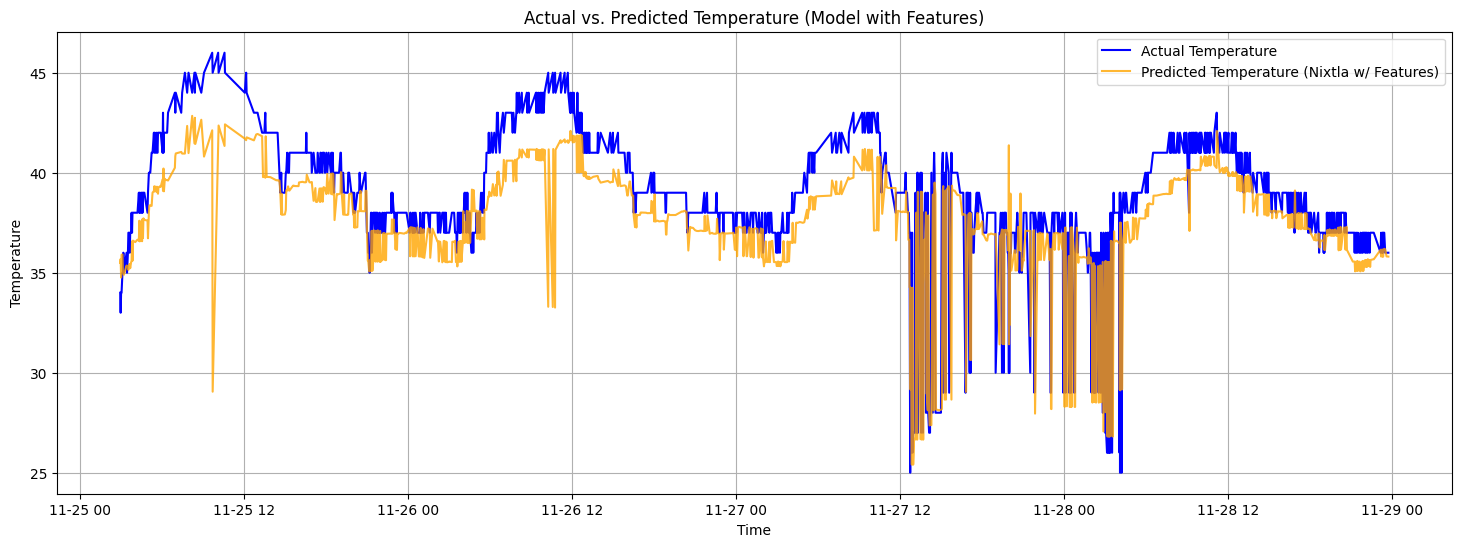

In [27]:
# Cell 20: Phase 4, Step 3: Visualize Results

if actual_vs_pred_df_fe is not None and not actual_vs_pred_df_fe.empty:
    print("\n--- Visualizing Actual vs. Predicted Results (Model with Features) ---")
    plt.figure(figsize=(18, 6))
    plt.plot(actual_vs_pred_df_fe.index, actual_vs_pred_df_fe[target_column], label='Actual Temperature', color='blue')
    plt.plot(actual_vs_pred_df_fe.index, actual_vs_pred_df_fe['predicted_temp'], label='Predicted Temperature (Nixtla w/ Features)', color='orange', alpha=0.8)
    plt.title('Actual vs. Predicted Temperature (Model with Features)')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nSkipping plot due to missing aligned actual/predicted data.")

In [28]:
# Cell 21: Phase 4, Step 4: Understand Rolling-Origin Cross-Validation (Conceptual Structure)

from sklearn.model_selection import TimeSeriesSplit

print("\n--- Rolling-Origin Cross-Validation (Conceptual Structure) ---")

# Use the full cleaned dataset prepared with features
data_for_cv = df_cleaned.copy() # df_cleaned has features and NaNs dropped

# Example parameters
n_splits = 5 # Number of folds
# test_size needs to be set. Using the feature horizon as an example,
# but this might need adjustment based on total data length and desired overlap.
test_size_cv = horizon_fe # Length of each test set in the CV split

if len(data_for_cv) > test_size_cv * (n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size_cv)
    print(f"Setting up {n_splits} splits for cross-validation with test_size={test_size_cv}.")
    print("NOTE: Full implementation requires running data prep and Nixtla forecast inside the loop - can be very slow!")

    split_num = 0
    all_cv_metrics = []

    # Loop structure - you would implement data prep & forecast steps inside
    for train_index, test_index in tscv.split(data_for_cv):
        split_num += 1
        print(f"\n--- CV Split {split_num}/{n_splits} ---")

        cv_train_full = data_for_cv.iloc[train_index]
        cv_test_full = data_for_cv.iloc[test_index] # This is the fold to predict

        print(f"  Train period: {cv_train_full.index.min()} to {cv_train_full.index.max()} ({len(cv_train_full)} points)")
        print(f"  Test period:  {cv_test_full.index.min()} to {cv_test_full.index.max()} ({len(cv_test_full)} points)")

    # After loop: Calculate overall metrics
    if all_cv_metrics:
         avg_mae = np.mean([m['MAE'] for m in all_cv_metrics])
         print("\n--- Overall CV Metrics (Conceptual Average) ---")
         print(f"  Average MAE across {n_splits} folds: {avg_mae:.4f}")
    else:
         print("\n--- Overall CV Metrics (Conceptual) ---")
         print("  Run the full loop to get actual average metrics.")
else:
    print(f"Dataset too small ({len(data_for_cv)} points) for {n_splits} splits with test_size {test_size_cv}.")


print("\nFor your report, describe this rolling-origin concept and explain that it provides a more")
print("robust evaluation than a single split. If you implement the full loop, report the overall")
print("metrics; otherwise, note it as a more robust method for future work.")


--- Rolling-Origin Cross-Validation (Conceptual Structure) ---
Dataset too small (27919 points) for 5 splits with test_size 5584.

For your report, describe this rolling-origin concept and explain that it provides a more
robust evaluation than a single split. If you implement the full loop, report the overall
metrics; otherwise, note it as a more robust method for future work.


In [29]:
# Cell 22: Phase 5, Step 1: Prepare Sequences for the VAE

import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K

print("\n--- Phase 5: Preparing Sequences for VAE ---")

def create_sequences(data, seq_length):
    """Creates overlapping sequences from time series data."""
    xs = []
    # Ensure we don't go out of bounds
    for i in range(len(data) - seq_length + 1):
        x = data[i:(i + seq_length)]
        xs.append(x)
    return np.array(xs)

# Define sequence length (hyperparameter, related to patterns like daily cycles)
# Using 24 assumes hourly data might have daily patterns. Adjust if needed.
sequence_length = 24 # Example: Use 24 data points per sequence

# Ensure sequence length isn't longer than available training data
# Use train_df_fe (training data with features, before Nixtla prep)
if sequence_length >= len(train_df_fe):
    print(f"Warning: sequence_length ({sequence_length}) >= training data length ({len(train_df_fe)}). Adjusting...")
    # Adjust sequence length to something smaller, e.g., 1/4th of the data
    sequence_length = max(1, len(train_df_fe) // 4)
    print(f"Adjusted sequence_length to: {sequence_length}")


# Use the SCALED temperature data from the training set WITH features (train_df_fe)
# We use the scaler_fe version as features might influence the scaling range
scaled_train_data_fe = train_df_fe[scaled_column_name_fe].values
print(f"Using scaled training data with shape: {scaled_train_data_fe.shape}")

# Create sequences
vae_train_sequences = create_sequences(scaled_train_data_fe, sequence_length)

# Reshape for VAE input: (number_of_sequences, sequence_length, num_features)
# Here, num_features is 1 because we only use the scaled temp for VAE input
if vae_train_sequences.size > 0:
    vae_train_sequences = vae_train_sequences.reshape((-1, sequence_length, 1))
    print(f"\nCreated {len(vae_train_sequences)} sequences for VAE training.")
    print(f"Shape of VAE training data: {vae_train_sequences.shape}")
else:
    print("\nERROR: No sequences created. Check sequence_length and input data.")
    # Handle error appropriately, maybe stop execution
    raise ValueError("Could not create VAE training sequences.")


--- Phase 5: Preparing Sequences for VAE ---
Using scaled training data with shape: (22335,)

Created 22312 sequences for VAE training.
Shape of VAE training data: (22312, 24, 1)


In [30]:
# Cell 23: Phase 5, Step 2: Build the VAE Model (Using Custom KL Loss Layer)

print("\n--- Building VAE Model ---")

# --- Dimensions ---
latent_dim = 8
input_shape_vae = (sequence_length, 1)


# --- Custom Layer for KL Divergence Calculation ---
class KLDivergenceLayer(layers.Layer):
    """ Custom layer to calculate KL divergence loss and add it """
    def __init__(self, name="kl_divergence_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        # No trainable weights needed

    def call(self, inputs):
        # Expects inputs to be a list/tuple: [z_mean, z_log_var]
        z_mean_layer, z_log_var_layer = inputs
        kl_batch_loss = 1 + z_log_var_layer - K.square(z_mean_layer) - K.exp(z_log_var_layer)
        kl_batch_loss = K.sum(kl_batch_loss, axis=-1)
        kl_batch_loss *= -0.5
        # Add the averaged KL loss to the layer using self.add_loss
        self.add_loss(K.mean(kl_batch_loss)) # Average over the batch
        # This layer doesn't modify the inputs, just adds loss
        # Often KL layers return z_mean for convenience, but not strictly needed
        return z_mean_layer # Or you could return inputs if needed elsewhere


# --- Encoder Network ---
encoder_inputs = layers.Input(shape=input_shape_vae, name='encoder_input')
x = layers.LSTM(64, activation='relu', return_sequences=True)(encoder_inputs)
x = layers.LSTM(32, activation='relu', return_sequences=False)(x)
x = layers.Dense(16, activation='relu')(x)
# Keep z_mean and z_log_var outputs
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# --- Sampling Layer ---
def sampling(args):
    z_mean_samp, z_log_var_samp = args
    batch = K.shape(z_mean_samp)[0]
    dim = K.int_shape(z_mean_samp)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean_samp + K.exp(0.5 * z_log_var_samp) * epsilon

# Sample z from the distribution defined by z_mean, z_log_var
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# --- Add KL Loss using the Custom Layer ---
# Pass z_mean and z_log_var to the custom layer
# The layer itself adds the loss via self.add_loss
# We don't strictly need the output of this layer, but call it to add it to the graph
_ = KLDivergenceLayer()([z_mean, z_log_var])

# Encoder model (for potential separate use, if needed)
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
print("\n--- Encoder Summary ---")
encoder.summary(line_length=100)


# --- Decoder Network ---
latent_inputs = layers.Input(shape=(latent_dim,), name='decoder_input')
x = layers.Dense(16, activation='relu')(latent_inputs)
x = layers.RepeatVector(sequence_length)(x)
x = layers.LSTM(32, activation='relu', return_sequences=True)(x)
x = layers.LSTM(64, activation='relu', return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'), name='decoder_output')(x)
# Decoder model definition remains the same
decoder = Model(latent_inputs, decoder_outputs, name='decoder')
print("\n--- Decoder Summary ---")
decoder.summary(line_length=100)


# --- VAE Model (Connecting Encoder and Decoder) ---
# Feed the sampled 'z' (output of Lambda layer) into the decoder
vae_outputs = decoder(z)
# Define the VAE model connecting original inputs to final decoder outputs
vae = Model(encoder_inputs, vae_outputs, name='vae')


# --- Compile VAE with Reconstruction Loss ONLY ---
# The KL loss is now added internally by the KLDivergenceLayer
# Compile using standard MSE loss for reconstruction
vae.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
# Alternatively: vae.compile(optimizer='adam', loss='mse')

print("\n--- VAE Summary (Combined) ---")
vae.summary(line_length=100)


--- Building VAE Model ---

--- Encoder Summary ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)  │ (None, 24, 1)           │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ lstm (LSTM)                 │ (None, 24, 64)          │         16,896 │ encoder_input[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ lstm_1 (LSTM)               │ (None, 32)              │         12,416 │ lstm[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense (Dense)               │ (None, 16)              │            528 │ lstm_1[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z_mean (Dense)              │ (None, 8)               │            136 │ dense[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z_log_var (Dense)           │ (None, 8)               │            136 │ dense[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z (Lambda)                  │ (None, 8)               │              0 │ z_mean[0][0],           │
│                             │                         │                │ z_log_var[0][0]         │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 30,112 (117.62 KB)

 Trainable params: 30,112 (117.62 KB)

 Non-trainable params: 0 (0.00 B)


--- Decoder Summary ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)                 │ (None, 8)                       │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_1 (Dense)                            │ (None, 16)                      │               144 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ repeat_vector (RepeatVector)               │ (None, 24, 16)                  │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_2 (LSTM)                              │ (None, 24, 32)                  │             6,272 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_3 (LSTM)                              │ (None, 24, 64)                  │            24,832 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ decoder_output (TimeDistributed)           │ (None, 24, 1)                   │                65 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 31,313 (122.32 KB)

 Trainable params: 31,313 (122.32 KB)

 Non-trainable params: 0 (0.00 B)


--- VAE Summary (Combined) ---


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)  │ (None, 24, 1)           │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ lstm (LSTM)                 │ (None, 24, 64)          │         16,896 │ encoder_input[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ lstm_1 (LSTM)               │ (None, 32)              │         12,416 │ lstm[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense (Dense)               │ (None, 16)              │            528 │ lstm_1[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z_mean (Dense)              │ (None, 8)               │            136 │ dense[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z_log_var (Dense)           │ (None, 8)               │            136 │ dense[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z (Lambda)                  │ (None, 8)               │              0 │ z_mean[0][0],           │
│                             │                         │                │ z_log_var[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ decoder (Functional)        │ (None, 24, 1)           │         31,313 │ z[0][0]                 │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 61,425 (239.94 KB)

 Trainable params: 61,425 (239.94 KB)

 Non-trainable params: 0 (0.00 B)


--- Training VAE ---
Starting VAE training for 30 epochs (batch_size=128)...
Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - loss: 0.0517 - val_loss: 0.0227
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0484 - val_loss: 0.0239
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0288 - val_loss: 0.0057
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0198 - val_loss: 0.0051
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0196 - val_loss: 0.0048
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0191 - val_loss: 0.0049
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0185 - val_loss: 0.0046
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0183 - val_loss: 0.0045
Epoch 9/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0184 - val_loss: 0.0046
Epoch 10/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0183 - val_loss: 0.0047
Epoch 11/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/s

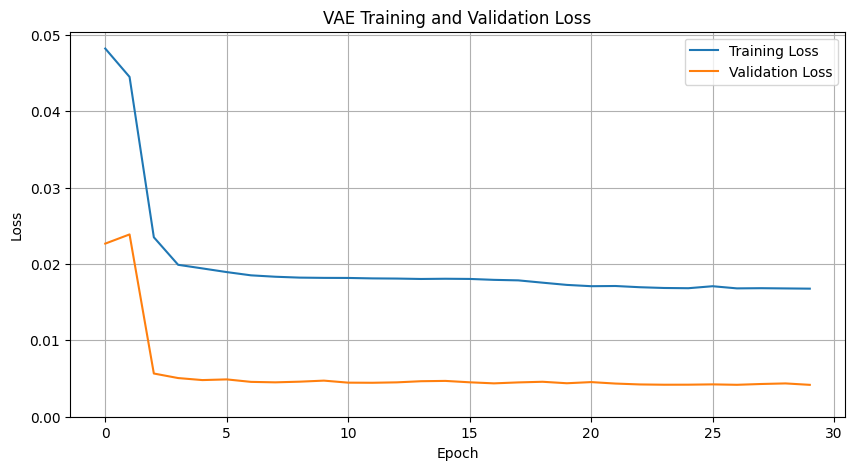

In [31]:
# Cell 24: Phase 5, Step 3: Train the VAE

print("\n--- Training VAE ---")

# Hyperparameters for training
epochs = 30 # Number of training iterations (adjust based on loss plot, e.g., 30, 50, 100)
batch_size = 128 # Number of sequences per training step (adjust based on memory, e.g., 64, 128, 256)
validation_split_ratio = 0.1 # Use 10% of data to monitor validation loss

print(f"Starting VAE training for {epochs} epochs (batch_size={batch_size})...")

# Ensure we have sequences to train on
# Check if 'vae' model and 'vae_train_sequences' exist from previous steps
if 'vae' in locals() and 'vae_train_sequences' in locals() and vae_train_sequences.size > 0:
    # Train the VAE model
    # Input is sequences, target is also sequences (autoencoder tries to reconstruct input)
    history = vae.fit(
        vae_train_sequences, # Input sequences
        # VAE with custom loss added via add_loss or defined in compile doesn't need y target here
        # If compiled with loss=vae_loss_fn, it still needs y_true, which is the input itself
        vae_train_sequences, # Target sequences (reconstruction) - provide input as target
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split_ratio, # Use part of data for validation
        shuffle=True, # Shuffle sequences each epoch
        verbose=1 # Show progress bar (0=silent, 1=progress bar, 2=one line per epoch)
    )

    print("VAE training finished.")

    # Plot training & validation loss
    if history is not None and 'loss' in history.history and 'val_loss' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('VAE Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.ylim(bottom=0) # Often useful to start y-axis at 0 for loss
        plt.show()
    else:
        print("Could not plot training history.")

else:
    print("ERROR: VAE model or training sequences not available. Cannot train VAE.")
    history = None # Ensure history is None if training didn't run


--- Generating Synthetic Data using VAE Decoder ---
Generating 22312 synthetic sequences (each length 24)...
Predicting with decoder using random latent vectors shape: (22312, 8)
698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Shape of generated sequences: (22312, 24, 1)
Generated 535488 synthetic data points (scaled).

Plotting sample comparison of Original vs Generated sequences...


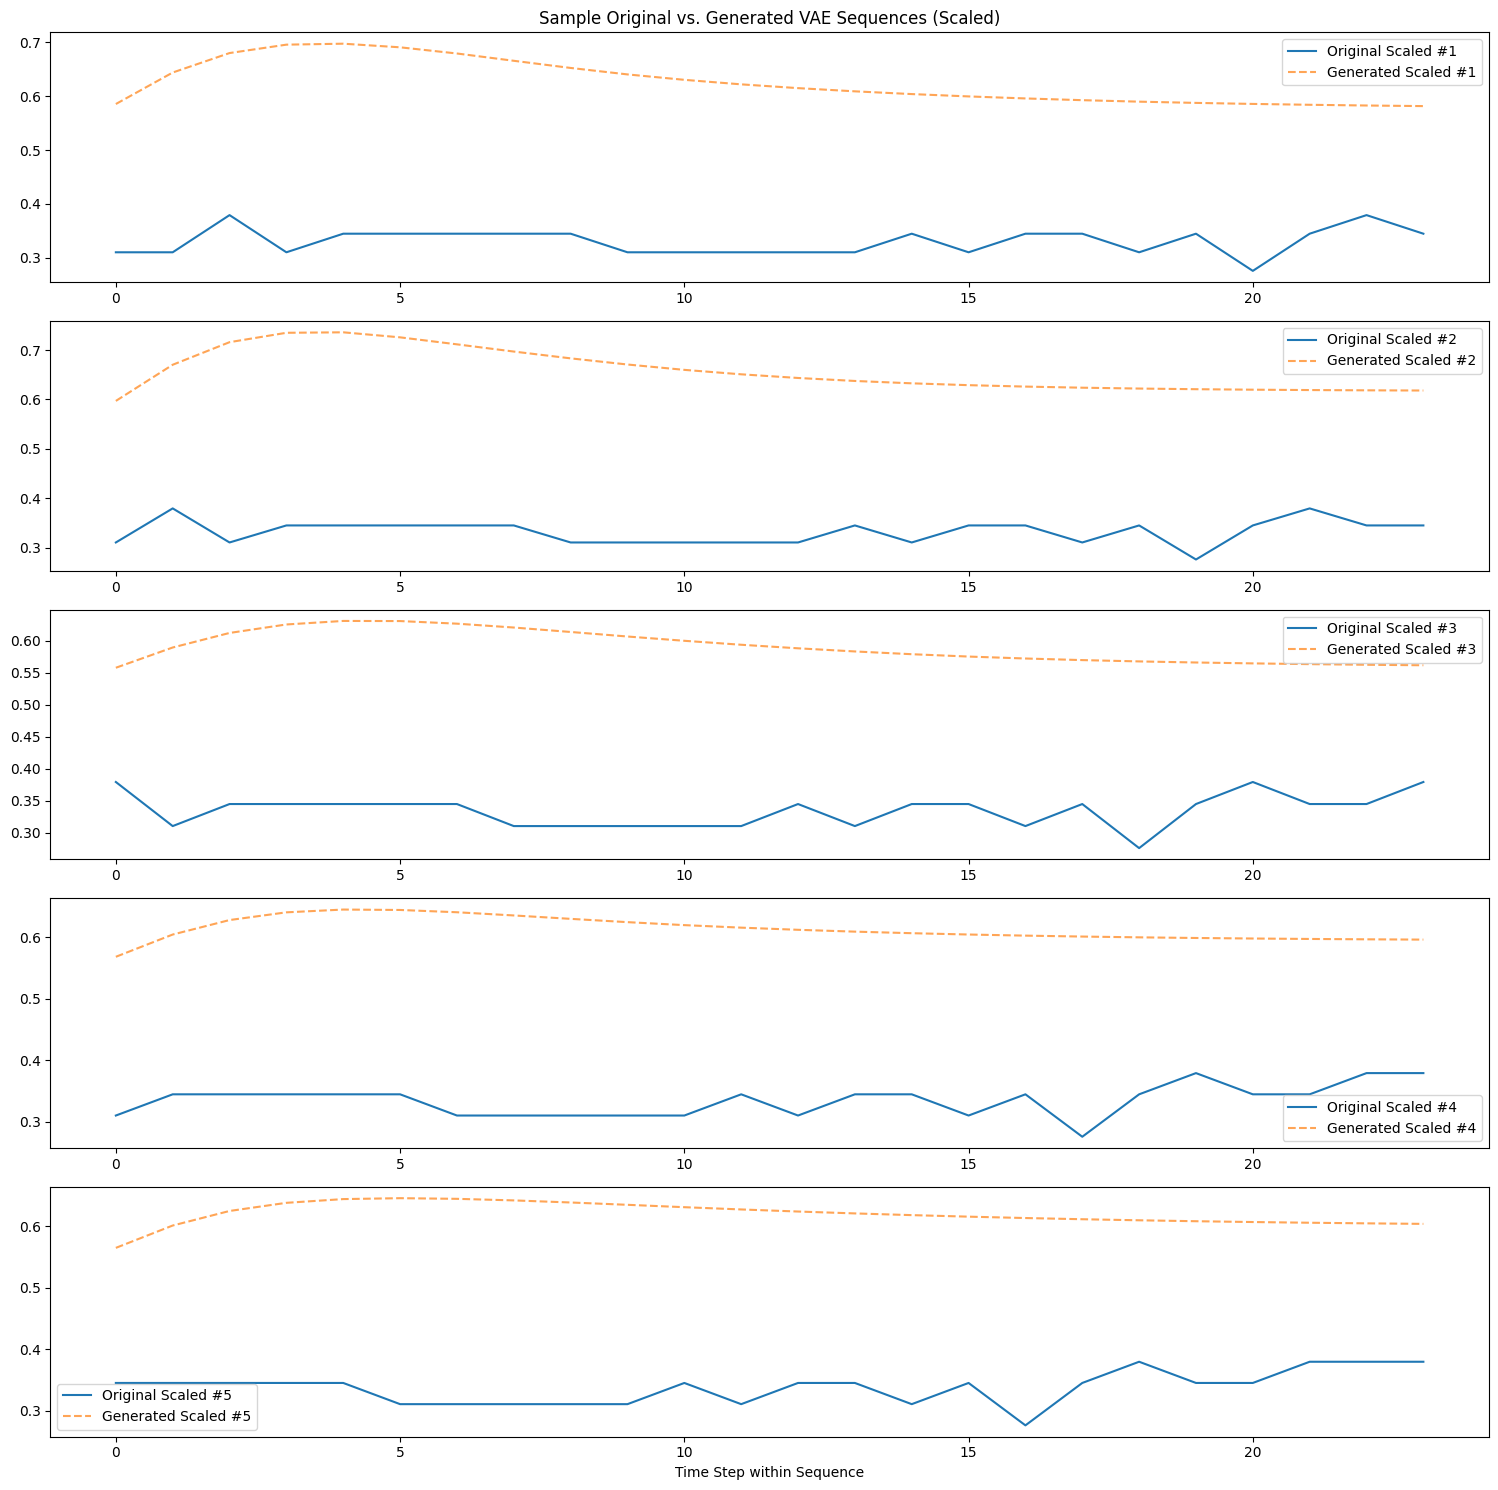

In [32]:
# Cell 25: Phase 5, Step 4: Generate Synthetic Data

print("\n--- Generating Synthetic Data using VAE Decoder ---")
generated_data_scaled = None # Initialize

# Check if VAE training was successful and models exist
# Also check if vae_train_sequences exists from Cell 22
if 'vae' in locals() and 'decoder' in locals() and 'encoder' in locals() and \
   'vae_train_sequences' in locals() and vae_train_sequences.size > 0 and \
   'history' in locals() and history is not None: # Check if training actually ran

    # Number of synthetic sequences to generate
    # Let's generate approximately the same amount of data as the original training sequences
    num_sequences_to_generate = len(vae_train_sequences)

    print(f"Generating {num_sequences_to_generate} synthetic sequences (each length {sequence_length})...")

    # Sample random points from the latent space (standard normal distribution)
    # Shape: (num_sequences, latent_dim)
    if 'latent_dim' not in locals():
         # Attempt to get latent_dim from decoder input shape if not defined globally
         try:
             latent_dim = decoder.input_shape[1]
             print(f"Inferred latent_dim from decoder input shape: {latent_dim}")
         except:
              raise NameError("Variable 'latent_dim' is not defined and couldn't be inferred. Please run Cell 23 first.")

    random_latent_vectors = np.random.normal(size=(num_sequences_to_generate, latent_dim))

    # Use the trained decoder to generate sequences from these random points
    # Wrap predict in try-except in case of issues
    try:
        print(f"Predicting with decoder using random latent vectors shape: {random_latent_vectors.shape}")
        generated_sequences_scaled = decoder.predict(random_latent_vectors)
        # Output shape: (num_sequences, sequence_length, 1)
        print(f"Shape of generated sequences: {generated_sequences_scaled.shape}")

        # Reshape generated sequences back into a flat 1D array of scaled temperature values
        generated_data_scaled = generated_sequences_scaled.reshape(-1) # Flatten into one long series
        print(f"Generated {len(generated_data_scaled)} synthetic data points (scaled).")

        # Plot a few generated sequences vs original sequences for comparison
        num_plot = 5 # Number of samples to plot
        # Check if enough sequences are available for plotting
        if len(vae_train_sequences) >= num_plot and len(generated_sequences_scaled) >= num_plot:
            print("\nPlotting sample comparison of Original vs Generated sequences...")
            plt.figure(figsize=(15, 3 * num_plot)) # Adjust height based on num_plot
            for i in range(num_plot):
                plt.subplot(num_plot, 1, i + 1)
                # Ensure sequence dimension exists before accessing
                if vae_train_sequences.ndim == 3 and generated_sequences_scaled.ndim == 3:
                     plt.plot(vae_train_sequences[i, :, 0], label=f'Original Scaled #{i+1}', linestyle='-')
                     plt.plot(generated_sequences_scaled[i, :, 0], label=f'Generated Scaled #{i+1}', alpha=0.7, linestyle='--')
                     plt.legend()
                     if i == 0:
                         plt.title('Sample Original vs. Generated VAE Sequences (Scaled)')
                else:
                     print(f"Skipping plot for index {i}, incorrect array dimensions.")
            plt.xlabel("Time Step within Sequence")
            plt.tight_layout()
            plt.show()
        else:
            print(f"Not enough sequences available to plot comparison (Need at least {num_plot}).")
            print(f"  Original sequences available: {len(vae_train_sequences)}")
            print(f"  Generated sequences available: {len(generated_sequences_scaled) if generated_sequences_scaled is not None else 0}")


    except Exception as e:
         print(f"ERROR during decoder prediction: {e}")
         generated_data_scaled = None # Ensure it's None on error


else:
    print("ERROR: VAE models/training history/sequences not found or training failed. Cannot generate synthetic data.")
    generated_data_scaled = None # Ensure this is None if generation fails

In [33]:
# Cell 26: Phase 5, Step 5: Augment Your Training Data (Minor change: Keep original scaled data separate)

print("\n--- Augmenting original training data with synthetic data ---")
augmented_nixtla_input = None # Initialize
original_y_scaled = None # Keep original separate

# Check if synthetic data generation was successful
if 'generated_data_scaled' in locals() and generated_data_scaled is not None and generated_data_scaled.size > 0:

    # --- Get Original Scaled Training Data (Target Only) ---
    if 'train_nixtla_input_fe_regular' in locals() and train_nixtla_input_fe_regular is not None:
        # Keep the original regularized training data
        original_y_scaled = train_nixtla_input_fe_regular[['unique_id', 'ds', 'y']].copy()
        print(f"Using regularized original training data (shape: {original_y_scaled.shape})")
    else:
        print("ERROR: Regularized training data ('train_nixtla_input_fe_regular') not found. Cannot augment.")
        raise ValueError("Required original training data for augmentation is missing.")

    # --- Create DataFrame for the generated data ---
    num_generated_points = len(generated_data_scaled)
    print(f"Number of synthetic data points generated: {num_generated_points}")
    last_original_ds = original_y_scaled['ds'].max()
    if 'freq_nixtla' not in locals() or freq_nixtla is None:
        raise ValueError("Nixtla frequency ('freq_nixtla') is not defined.")
    print(f"Last original timestamp: {last_original_ds}, Frequency: {freq_nixtla}")

    # Generate new timestamps STARTING AFTER the original data
    try:
        synthetic_ds = pd.date_range(
            start=last_original_ds + pd.Timedelta(value=1, unit=freq_nixtla),
            periods=num_generated_points, freq=freq_nixtla
        )
        print(f"Generated {len(synthetic_ds)} timestamps for synthetic data, from {synthetic_ds.min()} to {synthetic_ds.max()}")
    except Exception as e:
        print(f"Error generating date range for synthetic data with freq='{freq_nixtla}': {e}")
        # Add fallback logic if needed (like trying 'min' if freq_nixtla is 'T')
        raise

    synthetic_y_df = pd.DataFrame({
        'unique_id': 'sensor_1', 'ds': synthetic_ds, 'y': generated_data_scaled
    })

    # --- Concatenate original and synthetic 'y' data ---
    augmented_nixtla_input = pd.concat([original_y_scaled, synthetic_y_df], ignore_index=True)
    augmented_nixtla_input = augmented_nixtla_input.sort_values(by='ds').reset_index(drop=True)

    print(f"\nOriginal training data points: {len(original_y_scaled)}")
    print(f"Synthetic data points added: {len(synthetic_y_df)}")
    print(f"Augmented training data shape: {augmented_nixtla_input.shape}")

else:
    print("ERROR: Scaled generated data ('generated_data_scaled') not available or empty. Skipping augmentation.")
    augmented_nixtla_input = None


--- Augmenting original training data with synthetic data ---
Using regularized original training data (shape: (172548, 3))
Number of synthetic data points generated: 535488
Last original timestamp: 2018-11-25 02:54:00, Frequency: T
Generated 535488 timestamps for synthetic data, from 2018-11-25 02:55:00 to 2019-12-01 23:42:00

Original training data points: 172548
Synthetic data points added: 535488
Augmented training data shape: (708036, 3)


<ipython-input-33-2c1e3b1bc446>:30: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  start=last_original_ds + pd.Timedelta(value=1, unit=freq_nixtla),
<ipython-input-33-2c1e3b1bc446>:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  synthetic_ds = pd.date_range(


In [34]:
# Cell 27: Phase 5, Step 6: Re-train Forecasting Model (Corrected Input)

fcst_df_scaled_aug = None # Initialize forecast dataframe

# Check if original scaled data, augmented data, and frequency exist
if 'original_y_scaled' in locals() and original_y_scaled is not None and \
   'augmented_nixtla_input' in locals() and augmented_nixtla_input is not None and \
   'freq_nixtla' in locals() and freq_nixtla is not None and \
   'horizon_fe' in locals():

    horizon_aug = horizon_fe # Use same prediction horizon as feature model

    print(f"\n--- Re-training Nixtla using augmented data history ---")
    print(f"--- Predicting for the ORIGINAL test period ---")
    print(f"(model='timegpt-1-long-horizon', horizon={horizon_aug}, freq='{freq_nixtla}')...")

    print("NOTE: Training on full augmented data. Forecast will start AFTER synthetic data.")
    print("Evaluation will compare this late forecast period against the feature model's original test period results.")

    try:
        # Train on the FULL augmented 'y' data
        df_for_aug_forecast = augmented_nixtla_input[['unique_id', 'ds', 'y']]
        print(f"Using full augmented training data shape: {df_for_aug_forecast.shape}")

        fcst_df_scaled_aug = nixtla_client.forecast(
            df=df_for_aug_forecast, # Full augmented target data
            h=horizon_aug,          # Predict h steps AFTER augmented data
            freq=freq_nixtla,
            model='timegpt-1-long-horizon', # Or 'auto'
            level=[80, 95]
        )
        print("\nNixtla forecast (trained on augmented data) received:")
        print(fcst_df_scaled_aug.head())

    except Exception as e:
        print(f"\nERROR during Nixtla forecast on augmented data: {e}")
        fcst_df_scaled_aug = None
else:
    print("\nSkipping Nixtla forecast on augmented data due to missing input, freq, or horizon.")
    fcst_df_scaled_aug = None


--- Re-training Nixtla using augmented data history ---
--- Predicting for the ORIGINAL test period ---
(model='timegpt-1-long-horizon', horizon=5584, freq='T')...
NOTE: Training on full augmented data. Forecast will start AFTER synthetic data.
Evaluation will compare this late forecast period against the feature model's original test period results.
Using full augmented training data shape: (708036, 3)


/usr/local/lib/python3.11/dist-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)



Nixtla forecast (trained on augmented data) received:
  unique_id                  ds   TimeGPT  TimeGPT-hi-80  TimeGPT-hi-95  \
0  sensor_1 2019-12-01 23:43:00  0.640659       0.742272       0.807849   
1  sensor_1 2019-12-01 23:44:00  0.662885       0.785619       0.902164   
2  sensor_1 2019-12-01 23:45:00  0.695315       0.835048       0.955691   
3  sensor_1 2019-12-01 23:46:00  0.722964       0.870668       0.985174   
4  sensor_1 2019-12-01 23:47:00  0.729869       0.874012       0.976030   

   TimeGPT-lo-80  TimeGPT-lo-95  
0       0.539046       0.473468  
1       0.540151       0.423606  
2       0.555582       0.434939  
3       0.575260       0.460754  
4       0.585727       0.483708  



--- Evaluating performance of model trained on augmented data ---
--- WARNING: Comparing forecast AFTER synthetic data vs ACTUALS during original test period ---
Using prediction column: 'TimeGPT'
Using 'scaler_fe' for inverse transform.

Inverse transformed predictions (trained on augmented data):
                     predicted_temp
ds                                 
2019-12-01 23:43:00       40.579099
2019-12-01 23:44:00       41.223662
2019-12-01 23:45:00       42.164142
2019-12-01 23:46:00       42.965959
2019-12-01 23:47:00       43.166208

Shape after joining actuals and augmented predictions: (0, 2)
Aligned DataFrame is empty due to timestamp mismatch. Cannot calculate metrics directly.
--> Cannot directly compare performance on the same test period.

--- Metrics Comparison (Interpret with Caution) ---
Model with Features (Original Test Period): MAE=1.9358, RMSE=3.0403
Metrics for augmented model are unavailable for direct comparison due to timestamp mismatch.

--- Visualizing

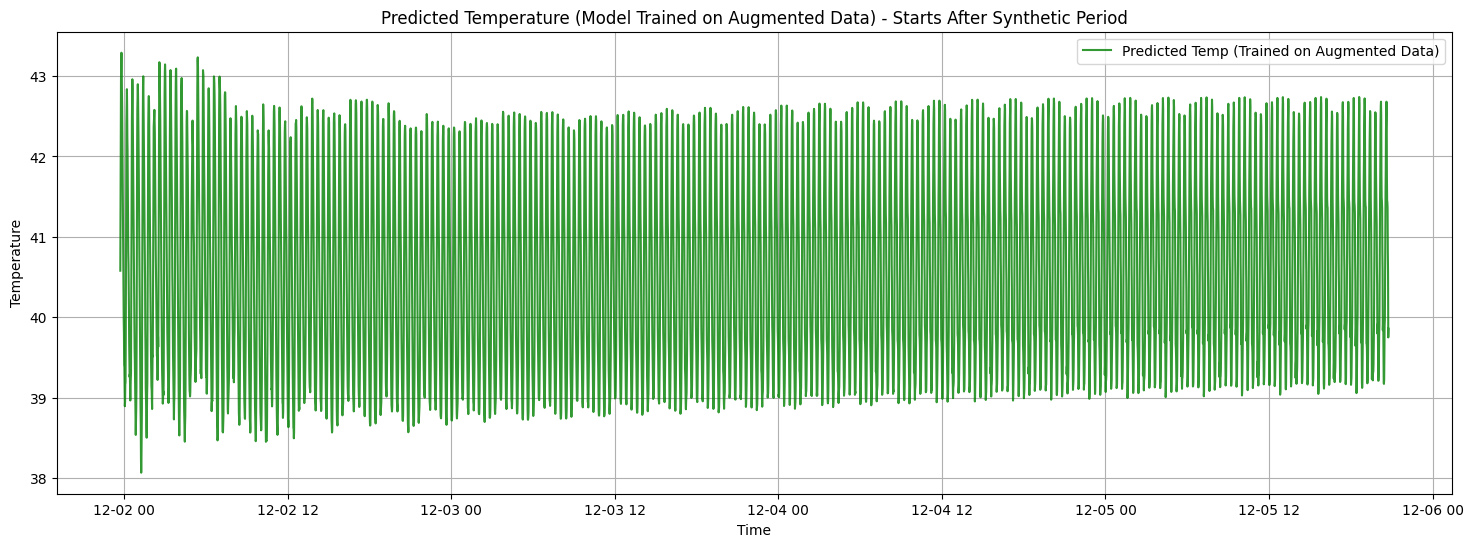

In [35]:
# Cell 28: Phase 5, Step 7: Evaluate Performance Improvement (Acknowledging Timestamp Mismatch)

predictions_df_aug = None # Initialize
metrics_aug = None
actual_vs_pred_aug_df = None # Initialize

if fcst_df_scaled_aug is not None:
    print("\n--- Evaluating performance of model trained on augmented data ---")
    print("--- WARNING: Comparing forecast AFTER synthetic data vs ACTUALS during original test period ---")

    # --- Inverse transform augmented model's predictions ---
    pred_col_name_aug = None
    possible_pred_cols_aug = [c for c in fcst_df_scaled_aug.columns if c not in ['unique_id', 'ds'] and '-lo-' not in c and '-hi-' not in c]

    if len(possible_pred_cols_aug) == 1:
        pred_col_name_aug = possible_pred_cols_aug[0]
        print(f"Using prediction column: '{pred_col_name_aug}'")
    elif 'TimeGPT-1-Long-Horizon' in fcst_df_scaled_aug.columns:
        pred_col_name_aug = 'TimeGPT-1-Long-Horizon'
        print(f"Using prediction column: '{pred_col_name_aug}'")
    else:
        print(f"Error: Could not find prediction column in augmented model output.")

    if pred_col_name_aug:
        if 'scaler_fe' in locals():
            print("Using 'scaler_fe' for inverse transform.")
            predicted_values_aug = scaler_fe.inverse_transform(fcst_df_scaled_aug[[pred_col_name_aug]])
            predictions_df_aug = pd.DataFrame({
                'ds': fcst_df_scaled_aug['ds'],
                'predicted_temp': predicted_values_aug.flatten()
            }).set_index('ds')
            print("\nInverse transformed predictions (trained on augmented data):")
            print(predictions_df_aug.head()) # These timestamps will be AFTER the synthetic data

            # --- Attempt to Align with actual test data ---
            # This join WILL likely result in an empty DataFrame as timestamps won't match
            if 'test_df_fe' in locals() and 'target_column' in locals():
                actual_df_aug = test_df_fe[[target_column]].copy()
                actual_vs_pred_aug_df = actual_df_aug.join(predictions_df_aug[['predicted_temp']], how='inner')
                print(f"\nShape after joining actuals and augmented predictions: {actual_vs_pred_aug_df.shape}")

                if not actual_vs_pred_aug_df.empty:
                    # This block is unlikely to execute based on the timestamp mismatch
                    print("\nAligned actual vs. predicted (augmented model):")
                    print(actual_vs_pred_aug_df.head())
                    actual_aug = actual_vs_pred_aug_df[target_column]
                    predicted_aug = actual_vs_pred_aug_df['predicted_temp']
                    mae_aug = mean_absolute_error(actual_aug, predicted_aug)
                    mse_aug = mean_squared_error(actual_aug, predicted_aug)
                    rmse_aug = np.sqrt(mse_aug)
                    print("\n--- Evaluation Metrics (Model Trained on Augmented Data) ---")
                    print(f"MAE:  {mae_aug:.4f}")
                    print(f"MSE:  {mse_aug:.4f}")
                    print(f"RMSE: {rmse_aug:.4f}")
                    metrics_aug = {'MAE': mae_aug, 'MSE': mse_aug, 'RMSE': rmse_aug}
                else:
                    print("Aligned DataFrame is empty due to timestamp mismatch. Cannot calculate metrics directly.")
                    print("--> Cannot directly compare performance on the same test period.")
                    metrics_aug = None # Metrics are unavailable for direct comparison
            else:
                print("Error: Cannot align data. 'test_df_fe' or 'target_column' not found.")
        else:
            print("Error: 'scaler_fe' not found. Cannot inverse transform predictions.")
    else:
        print("Skipping evaluation for augmented model as prediction column not found.")
else:
    print("\nSkipping evaluation for augmented model due to previous forecast error.")

# --- Compare Metrics ---
# This comparison is now less meaningful because the evaluation periods differ
print("\n--- Metrics Comparison (Interpret with Caution) ---")
if 'metrics_fe' in locals() and metrics_fe is not None:
    print(f"Model with Features (Original Test Period): MAE={metrics_fe['MAE']:.4f}, RMSE={metrics_fe['RMSE']:.4f}")
else:
    print("Metrics for model with features (no augmentation) are unavailable.")

if 'metrics_aug' in locals() and metrics_aug is not None: # Unlikely to be populated
    print(f"Model Trained on Augmented Data (Misaligned): MAE={metrics_aug['MAE']:.4f}, RMSE={metrics_aug['RMSE']:.4f}")
else:
    print("Metrics for augmented model are unavailable for direct comparison due to timestamp mismatch.")

# --- Plot augmented model results ---
# Plotting is also difficult due to mismatch. We can plot the prediction, but not against actuals.
if predictions_df_aug is not None:
     print("\n--- Visualizing Predicted Results (Model Trained on Augmented Data) ---")
     print("--- Cannot plot against actuals due to timestamp mismatch ---")
     plt.figure(figsize=(18, 6))
     plt.plot(predictions_df_aug.index, predictions_df_aug['predicted_temp'], label='Predicted Temp (Trained on Augmented Data)', color='green', alpha=0.8)
     plt.title('Predicted Temperature (Model Trained on Augmented Data) - Starts After Synthetic Period')
     plt.xlabel('Time')
     plt.ylabel('Temperature')
     plt.legend()
     plt.grid(True)
     plt.show()
else:
     print("\nSkipping plot for augmented model due to missing predictions.")